# Deep Learning & Art: Neural Style Transfer

This algorithm was created by [Gatys et al. (2015).](https://arxiv.org/abs/1508.06576)


In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline

Here I am using two images content image and style image and try to generate a new image.
Content Image in this code is TajMahal and the style image is the inner design of Mysore fort.


**Content Image**
<img src="images/tajmahal.jpeg" style ="width:750px;height:300px">


**Style Image**
<img src="images/mysorefort.jpg" style ="width:750px;height:300px">





For Neural Style Transfer we will use a concept called Transfer Learning where we use already pretrained model.
We will use this pretrained convolution network and build our model upon it. 

As per the original [Neural Style Paper] (https://arxiv.org/abs/1508.06576), I am using the VGG-19 network for this work. This network has already been trained on a large ImageNet data and has captured very low level features at shallow layers and high level features at deeper layers


In [2]:
pp = pprint.PrettyPrinter(indent=4)
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
pp.pprint(model)

{   'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>,
    'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>,
    'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>,
    'avgpool4': <tf.Tensor 'AvgPool_3:0' shape=(1, 19, 25, 512) dtype=float32>,
    'avgpool5': <tf.Tensor 'AvgPool_4:0' shape=(1, 10, 13, 512) dtype=float32>,
    'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) 

As you can see after loading the VGG-19 model, it has been stored in the dictionary format.

##  Neural Style Transfer (NST)

For this Neural style transfer algorithm we need to first build the cost function. This cost function will help the model to learn better and get a good image.

Here the cost function comprises of two parts, one is the cost or error between the generated image and content image which we call as **content cost function** and the other is the error between the generated image style and the style image which we call as the **style cost function**.

We shall denote each of them as below

- Content cost function $J_{content}(C,G)$
- Style cost function $J_{style}(S,G)$
- Total cost function $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 


Now we shall calculate the **content cost function** $J_{content}(C,G)$

We will first pass the content image through the network and extract the activations from a particular layer and lets call it $a^{(C)}$

Then again pass the generated image as the input to the VGG model then exract the activations and call it as $a^{(G)}$

$J_{content}(C,G)$
We will define the content cost function as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

$n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer you have chosen, and appear in a normalization term in the cost.

In [4]:

def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """

    # Retrieving dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G 
    a_C_unrolled = tf.reshape(a_C, shape=[m,n_H*n_W,n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m,n_H*n_W,n_C])
    
    # computing the total cost with tensorflow
    J_content = (tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))) /(4*n_H*n_W*n_C)
    
    return J_content

### 3.2 - Computing the style cost

After calculating the content cost, now proceeding with the style cost.

### 3.2.1 - Style matrix

#### Gram matrix
* The style matrix is also called a "Gram matrix." 
* In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. 
* In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large. 

#### Two meanings of the variable $G$
* Note that there is an unfortunate collision in the variable names used here. We are following common terminology used in the literature. 
* $G$ is used to denote the Style matrix (or Gram matrix) 
* $G$ also denotes the generated image. 
* For this assignment, we will use $G_{gram}$ to refer to the Gram matrix, and $G$ to denote the generated image.


#### Compute $G_{gram}$
In Neural Style Transfer (NST), you can compute the Style matrix by multiplying the "unrolled" filter matrix with its transpose:

<img src="images/NST_GM.png" style="width:900px;height:300px;">

$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$

#### $G_{(gram)i,j}$: correlation
The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters (channels). The value $G_{(gram)i,j}$ measures how similar the activations of filter $i$ are to the activations of filter $j$. 

#### $G_{(gram),i,i}$: prevalence of patterns or textures
* The diagonal elements $G_{(gram)ii}$ measure how "active" a filter $i$ is. 
* For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{(gram)ii}$ measures how common  vertical textures are in the image as a whole.
* If $G_{(gram)ii}$ is large, this means that the image has a lot of vertical texture. 


By capturing the prevalence of different types of features ($G_{(gram)ii}$), as well as how much different features occur together ($G_{(gram)ij}$), the Style matrix $G_{gram}$ measures the style of an image. 

In [1]:

def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    GA = tf.matmul(A,A, transpose_b = True)

    
    return GA

### 3.2.2 - Style cost

Our goal will be to minimize the distance between the Gram matrix of the "style" image S and the gram matrix of the "generated" image G. 
* For now, we are using only a single hidden layer $a^{[l]}$.  
* The corresponding style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

* $G_{gram}^{(S)}$ Gram matrix of the "style" image.
* $G_{gram}^{(G)}$ Gram matrix of the "generated" image.
* Remember, this cost is computed using the hidden layer activations for a particular hidden layer in the network $a^{[l]}$


In [9]:

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
 
    # Retrieving dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshaping the images to have them of shape (n_C, n_H*n_W) 
    a_S = tf.transpose(tf.reshape(a_S, shape=[m,n_H*n_W, n_C]),perm = [0,2,1])
    a_G = tf.transpose(tf.reshape(a_G, shape=[m,n_H*n_W, n_C]),perm = [0,2,1])

    # Computing gram_matrices for both images S and G 
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS, GG))) /(4*n_C*n_C*n_H*n_W*n_H*n_W)
    

    
    return J_style_layer

### 3.2.3 Style Weights

Till now we have captured the style from one layer only and now we need to compute from other layers and merge them. Each layer will be given some weights ($\lambda^{[l]}$) to show how much they contribute to the style


In [11]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

We shall combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 


In [12]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In the inner-loop of the for-loop above, `a_G` is a tensor and hasn't been evaluated yet. It will be evaluated and updated at each iteration when we run the TensorFlow graph in model_nn() below.



### 3.3 - Defining the total cost to optimize

Finally, let's create a cost function that minimizes both the style and the content cost. The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$



In [13]:


def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    

    J = alpha*J_content + beta * J_style

    
    return J


$\alpha$ and $\beta$ are hyperparameters that control the relative weighting between content and style.

## 4 - Solving the optimization problem

Finally, let's put everything together to implement Neural Style Transfer!


Here's what the program will have to do:

1. Create an Interactive Session
2. Load the content image 
3. Load the style image
4. Randomly initialize the image to be generated 
5. Load the VGG19 model
7. Build the TensorFlow graph:
    - Run the content image through the VGG19 model and compute the content cost
    - Run the style image through the VGG19 model and compute the style cost
    - Compute the total cost
    - Define the optimizer and the learning rate
8. Initialize the TensorFlow graph and run it for a large number of iterations, updating the generated image at every step.

Lets go through the individual steps in detail. 

#### Interactive Sessions

You've previously implemented the overall cost $J(G)$. We'll now set up TensorFlow to optimize this with respect to $G$. 
* To do so, your program has to reset the graph and use an "[Interactive Session](https://www.tensorflow.org/api_docs/python/tf/InteractiveSession)". 
* Unlike a regular session, the "Interactive Session" installs itself as the default session to build a graph.  
* This allows you to run variables without constantly needing to refer to the session object (calling "sess.run()"), which simplifies the code.  

#### Start the interactive session.

In [15]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

#### Content image
Let's load, reshape, and normalize our "content" image (the Louvre museum picture):

In [16]:
content_image = scipy.misc.imread("images/tajmahal.jpeg")
content_image = reshape_and_normalize_image(content_image)

#### Style image
Let's load, reshape and normalize our "style" image (Claude Monet's painting):

In [17]:
style_image = scipy.misc.imread("images/mysorefort.jpg")
style_image = reshape_and_normalize_image(style_image)

#### Generated image correlated with content image
Now, we initialize the "generated" image as a noisy image created from the content_image.

* The generated image is slightly correlated with the content image.
* By initializing the pixels of the generated image to be mostly noise but slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image. 
* Feel free to look in `nst_utils.py` to see the details of `generate_noise_image(...)`; to do so, click "File-->Open..." at the upper-left corner of this Jupyter notebook.

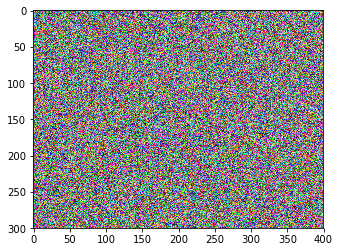

In [32]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0]);

#### Load pre-trained VGG19 model
Next, as explained in part (2), let's load the VGG19 model.

In [33]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

#### Content Cost

To get the program to compute the content cost, we will now assign `a_C` and `a_G` to be the appropriate hidden layer activations. We will use layer `conv4_2` to compute the content cost. The code below does the following:

1. Assign the content image to be the input to the VGG model.
2. Set a_C to be the tensor giving the hidden layer activation for layer "conv4_2".
3. Set a_G to be the tensor giving the hidden layer activation for the same layer. 
4. Compute the content cost using a_C and a_G.

**Note**: At this point, a_G is a tensor and hasn't been evaluated. It will be evaluated and updated at each iteration when we run the Tensorflow graph in model_nn() below.

In [34]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

#### Style cost

In [35]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)


* Now that you have J_content and J_style, computing the total cost J by calling `total_cost()`. 
* Use `alpha = 10` and `beta = 40`.

In [36]:

J = total_cost(J_content, J_style, alpha = 10, beta = 40)


### Optimizer

* Use the Adam optimizer to minimize the total cost `J`.
* Use a learning rate of 2.0.  
* [Adam Optimizer documentation](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer)

In [37]:
# define optimizer 
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step 
train_step = optimizer.minimize(J)

### Implementing the model

  



In [39]:
def model_nn(sess, input_image, num_iterations = 100):
    
    # Initialize global variables (you need to run the session on the initializer)
  
    sess.run(tf.global_variables_initializer())
   
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    
    sess.run(model['input'].assign(input_image))
    
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
       
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']

        generated_image = sess.run(model['input'])

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [40]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 7.41789e+09
content cost = 8218.11
style cost = 1.85445e+08
Iteration 20 :
total cost = 1.46528e+09
content cost = 15878.7
style cost = 3.66281e+07
Iteration 40 :
total cost = 4.41326e+08
content cost = 17969.1
style cost = 1.10287e+07
Iteration 60 :
total cost = 2.04585e+08
content cost = 18942.8
style cost = 5.10989e+06
Iteration 80 :
total cost = 1.3551e+08
content cost = 19673.9
style cost = 3.38283e+06


array([[[[ -37.02895737,   15.48471832,   23.80470085],
         [ -78.38672638,   -2.20150661,   17.33517647],
         [ -58.085289  ,   17.88737488,   12.90249443],
         ..., 
         [ -60.34440994,  -13.75077915,   27.71240807],
         [ -50.65803146,  -37.45770264,   39.00247192],
         [ -43.1814537 ,   -4.94139767,   47.68670273]],

        [[ -73.95298004,   11.90929508,   27.06881714],
         [ -58.58387375,   19.37792015,    3.49592781],
         [ -57.84436798,   23.61266327,    8.80917645],
         ..., 
         [ -52.28554916,    5.64429522,   19.12193108],
         [ -44.00185776,   -6.58120966,   26.11728859],
         [ -44.15561295,   -4.60725164,   31.31838989]],

        [[ -57.39733887,   18.33018684,  -14.81788731],
         [ -54.10014343,   15.80818558,   10.89246559],
         [ -62.06719208,   -1.53168309,    3.74632931],
         ..., 
         [ -41.72025681,   -2.03427935,  -18.87399673],
         [ -32.01311493,    4.18694162,   19.88415146],

**Expected Output**:

<table>
    <tr>
        <td>
            **Iteration 0 : **
        </td>
        <td>
           total cost = 5.05035e+09 <br>
           content cost = 7877.67 <br>
           style cost = 1.26257e+08
        </td>
    </tr>

</table>

The output image would be

<img src="images/generated_image.jpg" style="width:800px;height:300px;">




- Neural Style Transfer is an algorithm that given a content image C and a style image S can generate an artistic image
- It uses representations (hidden layer activations) based on a pretrained ConvNet. 
- The content cost function is computed using one hidden layer's activations.
- The style cost function for one layer is computed using the Gram matrix of that layer's activations. The overall style cost function is obtained using several hidden layers.
- Optimizing the total cost function results in synthesizing new images. 




### References:

The Neural Style Transfer algorithm was due to Gatys et al. (2015). Harish Narayanan and Github user "log0" also have highly readable write-ups from which we drew inspiration. The pre-trained network used in this implementation is a VGG network, which is due to Simonyan and Zisserman (2015). Pre-trained weights were from the work of the MathConvNet team. 

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) 
- Harish Narayanan, [Convolutional neural networks for artistic style transfer.](https://harishnarayanan.org/writing/artistic-style-transfer/)
- Log0, [TensorFlow Implementation of "A Neural Algorithm of Artistic Style".](http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style)
- Karen Simonyan and Andrew Zisserman (2015). [Very deep convolutional networks for large-scale image recognition](https://arxiv.org/pdf/1409.1556.pdf)
- [MatConvNet.](http://www.vlfeat.org/matconvnet/pretrained/)


In addition to the above the references I would like thank AndrewNg's course on Convolution Networks in Coursera which helped me in completing the above code successfully.